In [1]:
import numpy as np
from matplotlib import style
style.use("plotting.mplstyle")
import matplotlib.pyplot as plt
import sys
sys.path.append('./code/')
from gwBackground import dEdf
from constants import *
from astropy.cosmology import Planck15
from astropy import units as u

In [58]:
# For simplicity, start with a population of identical, equal-mass binaries
Mtot = 40.

# Frequencies at which we'll look at the stochastic background
freqs = np.linspace(10,1000,300)

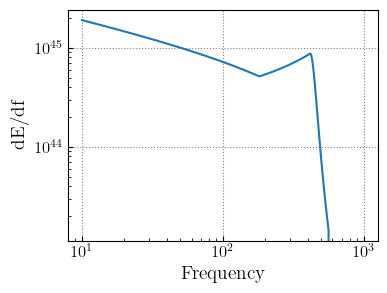

In [59]:
# Start by evaluating the radiated source-frame energy spectrum
dedf = dEdf(Mtot,freqs)

# Plot!
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(freqs,dedf)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency')
ax.set_ylabel('dE/df')
plt.show()

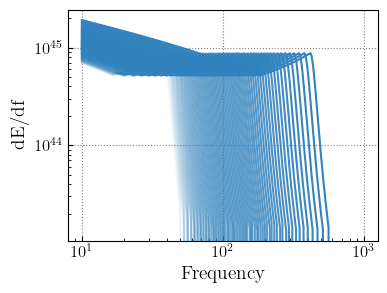

In [70]:
# We need to consider binaries across a range of redshifts,
# each of which will radiate their energy into a different range of detector-frame frequencies

# Define a grid of redshifts, and initialize an array to hold redshifted spectra
zs = np.linspace(0,10,100)
redshifted_dedf = np.zeros((zs.size,freqs.size))

# For each redshift, calculate the energy spectrum radiated by a single binary at that redshift.
# Remember that `freqs` is an array of *detector-frame* frequencies, and so we need to correspondingly *blue-shift*
# into the source frame
for i,z in enumerate(zs):
    redshifted_dedf[i,:] = dEdf(Mtot,freqs*(1.+z))

# Plot!
fig,ax = plt.subplots(figsize=(4,3))
for i in range(zs.size):
    ax.plot(freqs,redshifted_dedf[i,:],color='#3182bd',alpha=1.-float(i/zs.size))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency')
ax.set_ylabel('dE/df')
plt.show()

Total stochastic background amplitude is given by the integral over redshift

$$
\Omega(f) = \frac{f}{\rho_c} \int \frac{\frac{dE}{df}|_{f(1+z)} \mathcal{R}(z)}{(1+z) H(z)}dz
$$

where $dE/df$ is the energy spectrum radiated per binary, $\mathcal{R}(z)$ is the source-frame merger rate per unit volume at redshift $z$, and $H(z)$ the Hubble parameter at redshift $z$.
The leading factor of $f$ converts this from an energy per unit frequency to an energy per unit *log* frequency interval, while the factor of $1/\rho_c$ yields a dimensionless number.

In [61]:
# Calculate this!
# First define H(z). Note that this has units of 1/s
H_of_z = H0*np.sqrt(OmgM*(1.+zs)**3 + OmgL)

# For cartoonish simplicity, assume a uniform-in-comoving-volume rate out to z=6
# We'll specify this quantity in units of Gpc^{-3}*yr^{-1},
# but to match units in the integrand will convert to Mpc^{-3}*s^{-1}
R0_in_Gpc3_yr = np.where(zs<6,10,0)
R0_in_Mpc3_sec = R0_in_Gpc3_yr/1e9/year

# Take integral over redshift
redshift_integral = np.trapz(redshifted_dedf*R0_in_Mpc3_sec[:,np.newaxis]/((1.+zs)*H_of_z)[:,np.newaxis],zs,axis=0)
OmgGW = (freqs/rhoC)*redshift_integral

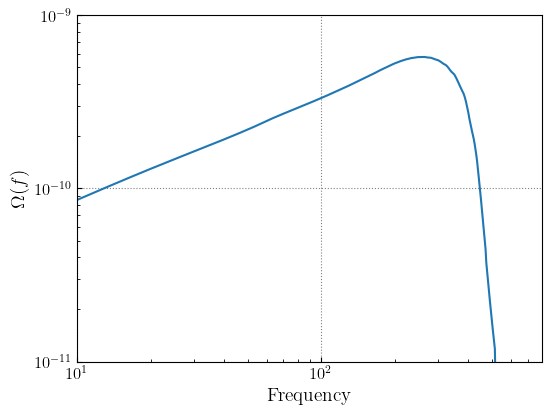

In [62]:
# Plot!
fig,ax = plt.subplots()
ax.plot(freqs,OmgGW)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10,800)
ax.set_ylim(1e-11,1e-9)
ax.set_xlabel('Frequency')
ax.set_ylabel('$\Omega(f)$')
plt.show()

In [63]:
# Next, let's see what exponential amplification does!
# Let's start by imagining a source at some fixed redshift
z_ref = 2.

# Compute the corresponding lookback time
lookback_time_ref = Planck15.lookback_time(z_ref).to(u.second).value

Ordinarily, we just have

$$
\frac{dE}{df}(f_\mathrm{det}) = \frac{dE}{df}(f_\mathrm{det}(1+z))
$$

Assume that radiated energy undergoes amplification via

$$
\frac{dE}{df}(f_\mathrm{det}) = \frac{dE}{df}(f_\mathrm{det}(1+z)) \, e^{\kappa\,t_\mathrm{look}(z) f_\mathrm{det}}
$$

I'm nearly positive that this should instead look something like

$$
\frac{dE}{df}(f_\mathrm{det}) = \frac{dE}{df}(f_\mathrm{det}(1+z)) \, e^{\kappa\int_0^z f_\mathrm{det}(1+z) dt_\mathrm{look}}
$$

but this is more complicated to code up than I want to deal with right now...

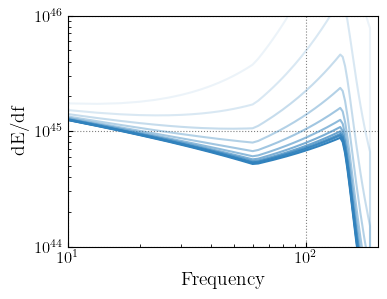

In [71]:
# Look at a range of kappa coefficients
kappas = np.concatenate([[0.],10.**np.linspace(-21,-19,10)])

# Instantiate array to hold observed energy spectrum at each kappa and each frequency
birefringent_dedf_demo = np.zeros((kappas.size,freqs.size))

# For each redshift, calculate the measured energy spectrum from by a single binary
for i,k in enumerate(kappas):
    birefringent_dedf_demo[i,:] = dEdf(Mtot,freqs*(1.+z_ref))*np.exp(k*lookback_time_ref*freqs)

# Plot!
fig,ax = plt.subplots(figsize=(4,3))
for i in range(kappas.size):
    ax.plot(freqs,birefringent_dedf_demo[i,:],color='#3182bd',alpha=1.-float(i/kappas.size))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency')
ax.set_ylabel('dE/df')
ax.set_xlim(10,200)
ax.set_ylim(1e44,1e46)
plt.show()

In [76]:
# Now let's try actually integrating over sources at many redshifts to get a stochastic background
# Define a full grid of redshifts and compute lookback times to each redshift
zs = np.linspace(0,10,1000)
lookback_times = Planck15.lookback_time(zs).to(u.second).value

# Initialize an array to hold spectra from binaries at each redshift, under each different kappa
kappas = np.concatenate([[0.],10.**np.linspace(-20,-18,10)])
birefringent_dedf = np.zeros((kappas.size,zs.size,freqs.size))

# For each redshift, calculate the energy spectrum observed from a single binary
for i,k in enumerate(kappas):
    birefringent_dedf[i,:,:] = np.array([dEdf(Mtot,freqs*(1.+z))*np.exp(k*lookback_times[ii]*freqs) for ii,z in enumerate(zs)])
    
H_of_z = H0*np.sqrt(OmgM*(1.+zs)**3 + OmgL)

# For cartoonish simplicity, assume a uniform-in-comoving-volume rate out to z=6
# We'll specify this quantity in units of Gpc^{-3}*yr^{-1},
# but to match units in the integrand will convert to Mpc^{-3}*s^{-1}
R0_in_Gpc3_yr = np.where(zs<6,10,0)
R0_in_Mpc3_sec = R0_in_Gpc3_yr/1e9/year

# Take integral over redshift
redshift_integral = np.trapz(birefringent_dedf*R0_in_Mpc3_sec[np.newaxis,:,np.newaxis]/((1.+zs)*H_of_z)[np.newaxis,:,np.newaxis],zs,axis=1)
OmgGW = (freqs[np.newaxis,:]/rhoC)*redshift_integral


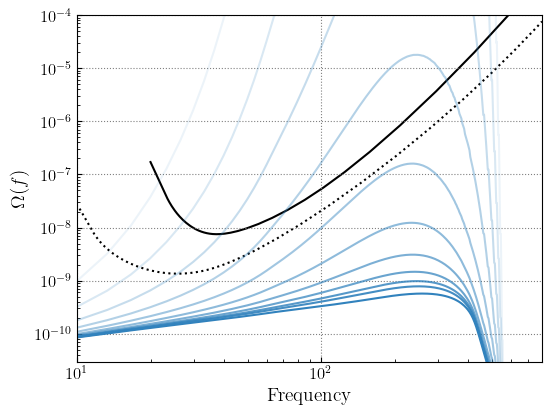

In [84]:
# Plot!

O3_PI_freqs,O3_PI = np.loadtxt('./input/O3PICurve.dat',unpack=True,usecols=(0,2),skiprows=4)
design_PI_freqs,design_PI = np.loadtxt('./input/Design_HLV_flow_10.txt',unpack=True,usecols=(0,1))

fig,ax = plt.subplots()
for i in range(kappas.size):
    ax.plot(freqs,OmgGW[i,:],color='#3182bd',alpha=1.-float(i/kappas.size))
    
ax.plot(O3_PI_freqs,O3_PI,color='black',zorder=-1)
ax.plot(design_PI_freqs,design_PI,color='black',ls=':',zorder=-1)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10,800)
ax.set_ylim(3e-11,1e-4)
ax.set_xlabel('Frequency')
ax.set_ylabel('$\Omega(f)$')
plt.show()